# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Problem Statement

Taking input datasets containing information about Starbucks customers, transactions, and product offers the objective is to optimize the demographic groups that best respond to each offer in Starbucks' portfolio.

To do that, the following steps have been followed:

I. [Data analysis and visualization](#DataAnalysisVisualization)<br>
II. [Data cleaning and preprocessing](#DataCleaning)<br>
III. [Model implementation](#ModelImplementation)<br>
IV. [Model evaluation and validation](#ModelEvaluation)<br>

* Refinement of the algorithms and selection of best model

At the end, the best algorithm for this application will be selected and a determination of the product offer that should be targeted to each demographic will be found out.

In [357]:
# Import packages
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

# Model packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# <a class="anchor" id="DataAnalysisVisualization">I. Data Analysis and Visualization

## 1. Porfolio dataset

In [262]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [263]:
portfolio.shape

(10, 6)

In [264]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [265]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [266]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [267]:
# Group-by the offers by type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

## 2. Profile dataset

In [268]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [269]:
profile.shape

(17000, 5)

In [270]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [271]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [272]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

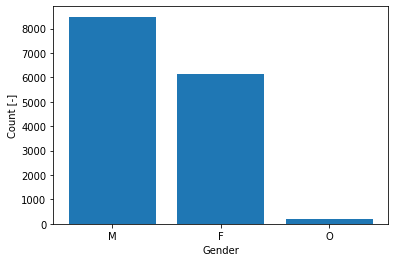

In [273]:
# Distribution of customers by gender
genderCounts = profile.gender.value_counts()
xGender = ['M', 'F', 'O']
plt.bar(xGender, height = genderCounts);
plt.xlabel('Gender');
plt.ylabel('Count [-]');

In [274]:
# Percentage of people by gender
genderCounts = profile.gender.value_counts()
genderPerc = genderCounts/(genderCounts.sum())*100
genderPerc

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

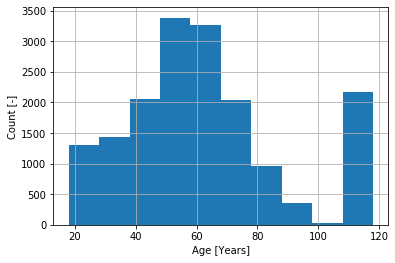

In [275]:
# Distribution of customers by age
plt.hist(profile['age'], bins = 10);
plt.xlabel('Age [Years]')
plt.ylabel('Count [-]');
plt.grid('on')

In [276]:
# Value counts for age
profile['age'].value_counts().sort_index()

18       70
19      135
20      135
21      140
22      131
       ... 
98        5
99        5
100      12
101       5
118    2175
Name: age, Length: 85, dtype: int64

In [277]:
maxAge = max(profile['age'])
profile[profile['age'] == maxAge].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [278]:
dfMaxAge = profile[profile['age'] == maxAge];
print('Null gender values: ', dfMaxAge.gender.isnull().sum())
print('Null income values: ', dfMaxAge.income.isnull().sum())

Null gender values:  2175
Null income values:  2175


There seems to be some bogus customers' ages since there are 2175 people of age 118 years, but no gender nor income values. These values will not be considered as part of the valid customers data.

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


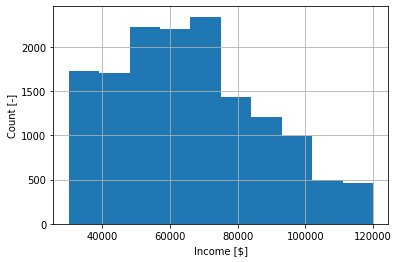

In [279]:
# Distribution of customers by income
plt.hist(profile['income'], bins = 10);
plt.xlabel('Income [$]');
plt.ylabel('Count [-]');
plt.grid('on');

## 3. Transcript dataset

In [280]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [281]:
transcript.shape

(306534, 4)

In [282]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [283]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

Text(0, 0.5, 'Count [-]')

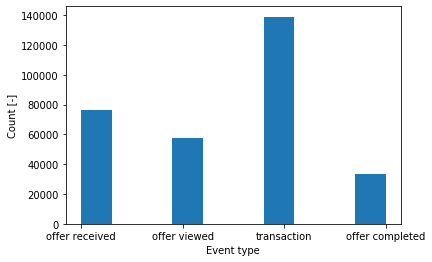

In [284]:
# Distribution of events
plt.hist(transcript['event']);
plt.xlabel('Event type');
plt.ylabel('Count [-]')

In [285]:
eventCounts = transcript['event'].value_counts();
eventPerc = eventCounts/eventCounts.sum()*100;
print(eventPerc)

transaction        45.330371
offer received     24.883700
offer viewed       18.831516
offer completed    10.954413
Name: event, dtype: float64


The transaction data remains the most interesting one since it is data that reveals how customers buy products without the need of an offer. From there, valuable information can be extracted to assess their reaction to a product offer.

In [286]:
# Dataframe with only transaction data for later use
dfTransaction = transcript[transcript['event'] == 'transaction']

In [287]:
dfTransaction.head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


# <a class="anchor" id="DataCleaning">II. Data Cleaning and Preprocessing

## 1. Portfolio dataset

In [288]:
# Copy of the portfolio dataset for cleaning and preprocessing
dfPortfolio = portfolio.copy()

In [289]:
dfPortfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [290]:
# Rename ID to differentiate between datasets
dfPortfolio.rename(columns = {'id': 'offerID'}, inplace = True)

In [291]:
# Normalize the reward and difficulty features for better
# processing with models

# Use MinMaxScaler to normalize
scaler = MinMaxScaler()
features = ['reward', 'difficulty']

# Substitute features with normalized ones
dfPortfolio[features] = scaler.fit_transform(dfPortfolio[features])
dfPortfolio.head()

,reward,channels,difficulty,duration,offer_type,offerID
0,1.0,"[email, mobile, social]",0.50,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1.0,"[web, email, mobile, social]",0.50,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0.0,"[web, email, mobile]",0.00,4,informational,3f207df678b143eea3cee63160fa8bed
3,0.5,"[web, email, mobile]",0.25,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,0.5,"[web, email]",1.00,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [292]:
# Use one-hot encoding for the channels feature
channels = ['email', 'mobile', 'social'];
for i in channels:
    dfPortfolio[i] = dfPortfolio['channels'].apply(lambda x: 1 if i in x else 0)

In [293]:
# Drop channels feature to avoid repetition
dfPortfolio.drop('channels', axis = 1, inplace = True)
dfPortfolio.head()

,reward,difficulty,duration,offer_type,offerID,email,mobile,social
0,1.0,0.50,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1
1,1.0,0.50,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1
2,0.0,0.00,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0
3,0.5,0.25,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0
4,0.5,1.00,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


In [294]:
# Ennumerate offerID for simplicity
listOfferID = dfPortfolio['offerID'].tolist()

enOfferID = {'offerID': {k: v for k, v in zip(listOfferID, list(range(1, len(listOfferID) + 1)))}}
print(enOfferID)

{'offerID': {'ae264e3637204a6fb9bb56bc8210ddfd': 1, '4d5c57ea9a6940dd891ad53e9dbe8da0': 2, '3f207df678b143eea3cee63160fa8bed': 3, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 4, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5, '2298d6c36e964ae4a3e7e9706d1fb8c2': 6, 'fafdcd668e3743c1bb461111dcafc2a4': 7, '5a8bc65990b245e5a138643cd4eb9837': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, '2906b810c7d4411798c6938adc9daaa5': 10}}


In [295]:
# Replace in dfPortfolio
dfPortfolio.replace(enOfferID, inplace = True)
dfPortfolio.head()

,reward,difficulty,duration,offer_type,offerID,email,mobile,social
0,1.0,0.50,7,bogo,1,1,1,1
1,1.0,0.50,5,bogo,2,1,1,1
2,0.0,0.00,4,informational,3,1,1,0
3,0.5,0.25,7,bogo,4,1,1,0
4,0.5,1.00,10,discount,5,1,0,0


In [296]:
# Convert offer_type to ennumerate too
listOfferType = dfPortfolio['offer_type'].astype('category').cat.categories.tolist()

enOfferType = {'offer_type': {k: v for k, v in zip(listOfferType,
                    list(range(1, len(listOfferType) + 1)))}}
print(enOfferType)

{'offer_type': {'bogo': 1, 'discount': 2, 'informational': 3}}


In [297]:
# Replace in dfPortfolio
dfPortfolio.replace(enOfferType, inplace = True)

## 2. Profile dataset

In [298]:
# Copy of the portfolio dataset for cleaning and preprocessing
dfProfile = profile.copy()

In [299]:
# Rename ID to differentiate between datasets
dfProfile.rename(columns = {'id': 'customerID'}, inplace = True)

In [300]:
# Ennumerate customerID for simplicity
listCustomerID = dfProfile['customerID'].tolist()

enCustomerID = {'customerID': {k: v for k, v in zip(listCustomerID, list(range(1, len(listCustomerID) + 1)))}}

In [301]:
# Replace in dfProfile
dfProfile.replace(enCustomerID, inplace = True)
dfProfile.head()

,gender,age,customerID,became_member_on,income
0,None,118,1,20170212,NaN
1,F,55,2,20170715,112000.0
2,None,118,3,20180712,NaN
3,F,75,4,20170509,100000.0
4,None,118,5,20170804,NaN


All the features of this dataset will be processed to have numerical values so they can be later used in a ML model. For that, when applicable all the data points will be classified into groups for easier analysis.

In [302]:
# Age processing
# First they false data points with age 118 will be removed to
# clean the data set, setting first all those values to NaN
dfProfile['age'] = dfProfile['age'].apply(lambda x: np.nan if
                                          x == 118 else x)

In [303]:
# Then, all the NaN values are removed from the data set
dfProfile.dropna(inplace = True)
dfProfile.isna().sum()

gender              0
age                 0
customerID          0
became_member_on    0
income              0
dtype: int64

In [304]:
# Four age groups are established: teenage, young-adult, adult,
# and elderly
dfProfile['ageGroup'] = pd.cut(dfProfile['age'], bins = [18, 25, 35, 65, 103], 
                               labels = ['teenager', 'young-adult', 'adult', 'elderly'])
dfProfile['ageGroup'].head()

1       adult
3     elderly
5     elderly
8       adult
12      adult
Name: ageGroup, dtype: category
Categories (4, object): [teenager < young-adult < adult < elderly]

In [305]:
# Convert age groups into numerical values
ageGroupList = dfProfile['ageGroup'].astype('category').cat.categories.tolist()
ageGroupNum = {'ageGroup': {k: v for k, v in zip(ageGroupList, 
                            list(range(1, len(ageGroupList) + 1)))}}
print(ageGroupNum)

{'ageGroup': {'teenager': 1, 'young-adult': 2, 'adult': 3, 'elderly': 4}}


In [306]:
# Replace in dfProfile
dfProfile.replace(ageGroupNum, inplace = True)
dfProfile['ageGroup'].head()

1     3.0
3     4.0
5     4.0
8     3.0
12    3.0
Name: ageGroup, dtype: float64

In [307]:
# Gender preprocessing
# Convert gender types into numerical values
genderList = dfProfile['gender'].astype('category').cat.categories.tolist()
genderNum = {'gender': {k: v for k, v in zip(genderList, 
                                    list(range(1, len(genderList) + 1)))}}

# Replace in dfProfile
dfProfile.replace(genderNum, inplace = True)

In [308]:
print(genderNum)

{'gender': {'F': 1, 'M': 2, 'O': 3}}


In [309]:
dfProfile.head()

,gender,age,customerID,became_member_on,income,ageGroup
1,1,55.0,2,20170715,112000.0,3.0
3,1,75.0,4,20170509,100000.0,4.0
5,2,68.0,6,20180426,70000.0,4.0
8,2,65.0,9,20180209,53000.0,3.0
12,2,58.0,13,20171111,51000.0,3.0


In [310]:
# Income preprocessing
# Three categories of income are established: low, average and high
dfProfile['incomeGroup'] = pd.cut(dfProfile['income'], bins = [30000, 60000, 90000, 120000], labels = ['low', 'average', 'high'])

In [311]:
# Convert income groups into numerical values
incomeList = dfProfile['incomeGroup'].astype('category').cat.categories.tolist()
incomeGroupNum = {'incomeGroup': {k: v for k, v in zip(incomeList, 
                                          list(range(1, len(incomeList) + 1)))}}

# Replace in dfProfile
dfProfile.replace(incomeGroupNum, inplace = True)

print(incomeGroupNum)

{'incomeGroup': {'low': 1, 'average': 2, 'high': 3}}


In [312]:
dfProfile.head()

,gender,age,customerID,became_member_on,income,ageGroup,incomeGroup
1,1,55.0,2,20170715,112000.0,3.0,3.0
3,1,75.0,4,20170509,100000.0,4.0,3.0
5,2,68.0,6,20180426,70000.0,4.0,2.0
8,2,65.0,9,20180209,53000.0,3.0,1.0
12,2,58.0,13,20171111,51000.0,3.0,1.0


In [313]:
# Membership date preprocessing
# Convert to datetime format
dfProfile['became_member_on'] = pd.to_datetime(dfProfile['became_member_on'], 
                                              format = '%Y%m%d')

In [314]:
# From this data, the year when the customers signed up and the
# days since they became members can be extracted as new columns
dfProfile['membershipYear'] = dfProfile['became_member_on'].dt.year

dfProfile['membershipDays'] = datetime.datetime.today().date() - dfProfile['became_member_on'].dt.date
dfProfile['membershipDays'] = dfProfile['membershipDays'].dt.days

In [315]:
dfProfile.head()

,gender,age,customerID,became_member_on,income,ageGroup,incomeGroup,membershipYear,membershipDays
1,1,55.0,2,2017-07-15,112000.0,3.0,3.0,2017,1241
3,1,75.0,4,2017-05-09,100000.0,4.0,3.0,2017,1308
5,2,68.0,6,2018-04-26,70000.0,4.0,2.0,2018,956
8,2,65.0,9,2018-02-09,53000.0,3.0,1.0,2018,1032
12,2,58.0,13,2017-11-11,51000.0,3.0,1.0,2017,1122


In [316]:
# Depending on the time a person has been customer, three categories
# are established: newcomer, regular, loyal
dfProfile ['memberLevel'] = pd.cut(dfProfile['membershipDays'], 
                                  bins = [365, 730, 1095, 2500],
                                  labels = ['newcomer', 'regular', 'loyal'])

In [317]:
# Convert member groups into numerical values
memberList = dfProfile['memberLevel'].astype('category').cat.categories.tolist()
memberNum = {'memberLevel': {k: v for k, v in zip(memberList,
                                list(range(1, len(memberList) + 1)))}}

# Replace in dfProfile
dfProfile.replace(memberNum, inplace = True)
print(memberNum)

{'memberLevel': {'newcomer': 1, 'regular': 2, 'loyal': 3}}


In [318]:
dfProfile.head()

,gender,age,customerID,became_member_on,income,ageGroup,incomeGroup,membershipYear,membershipDays,memberLevel
1,1,55.0,2,2017-07-15,112000.0,3.0,3.0,2017,1241,3.0
3,1,75.0,4,2017-05-09,100000.0,4.0,3.0,2017,1308,3.0
5,2,68.0,6,2018-04-26,70000.0,4.0,2.0,2018,956,2.0
8,2,65.0,9,2018-02-09,53000.0,3.0,1.0,2018,1032,2.0
12,2,58.0,13,2017-11-11,51000.0,3.0,1.0,2017,1122,3.0


In [319]:
# Delete the original columns gender, age, became_member_on, income,
# and derived column membershipDays. Since the data is now preprocessed,
# and classified, they are not needed anymore
dfProfile.drop(columns = ['gender', 'age', 'became_member_on', 'income',
                         'membershipDays'], axis = 1, inplace = True)
print(dfProfile.columns)


Index(['customerID', 'ageGroup', 'incomeGroup', 'membershipYear',
       'memberLevel'],
      dtype='object')


In [320]:
dfProfile.head()

,customerID,ageGroup,incomeGroup,membershipYear,memberLevel
1,2,3.0,3.0,2017,3.0
3,4,4.0,3.0,2017,3.0
5,6,4.0,2.0,2018,2.0
8,9,3.0,1.0,2018,2.0
12,13,3.0,1.0,2017,3.0


## 3. Transcript dataset

In [321]:
# Copy of the transcript dataset for cleaning and preprocessing
dfTranscript = transcript.copy()

In [322]:
dfTranscript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [323]:
# Person preprocessing
# First, the name is changed to customerID to align with other
# datasets
dfTranscript.rename(columns = {'person': 'customerID'}, inplace = True)

In [324]:
# Convert complicate customerID to easier ennumeration as done
# with profile dataset
dfTranscript.replace(enCustomerID, inplace = True)
dfTranscript['customerID'].head()

0    4
1    5
2    6
3    7
4    8
Name: customerID, dtype: int64

In [325]:
# Event preprocessing
# The different type of events possible are the following:
dfTranscript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

The "transaction" events do not provide additional information on the relationship between customer demographics and offers. The same applies to the "offer received", since this type of events does not allow us to better target the potential targets for new offers.


In [326]:
# Then, for the time being these data points will be removed from the dataset
dfTranscript = dfTranscript[dfTranscript['event'] != 'transaction']
dfTranscript = dfTranscript[dfTranscript['event'] != 'offer received']

dfTranscript['event'].unique()

array(['offer viewed', 'offer completed'], dtype=object)

In [327]:
# Convert events into numerical values
eventList = dfTranscript['event'].astype('category').cat.categories.tolist()

eventNum = {'event': {k: v for k, v in zip(eventList, 
                                list(range(1, len(eventList) + 1)))}}
print(eventNum)

{'event': {'offer completed': 1, 'offer viewed': 2}}


In [328]:
# Replace in dfTranscript
dfTranscript.replace(eventNum, inplace = True)
dfTranscript.head()

,customerID,event,value,time
12650,9,2,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,32,2,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,36,2,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,42,2,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,49,2,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [329]:
# Value preprocessing
# First, extraction of keys in value dictionary
valKeys = []
for ix, val in dfTranscript.iterrows():
    for k in val['value']:
        if k in valKeys:
            continue
        else:
            valKeys.append(k)

print(valKeys)

['offer id', 'offer_id', 'reward']


In [330]:
# Initialise each key to force data types
dfTranscript['offer_id'] = ''
dfTranscript['amount'] = 0
dfTranscript['reward'] = 0

In [331]:
# Separate value keys into different columns
for ix, val in dfTranscript.iterrows():
    for k in val['value']:
        if k == 'offer_id' or k == 'offer id':
            dfTranscript.at[ix, 'offer_id'] = val['value'][k]
        elif k == 'amount':
            dfTranscript.at[ix, 'amount'] = val['value'][k]
        elif k == 'reward':
            dfTranscript.at[ix, 'reward'] = val['value'][k]


In [332]:
dfTranscript.head()

,customerID,event,value,time,offer_id,amount,reward
12650,9,2,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,0,0
12651,32,2,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,5a8bc65990b245e5a138643cd4eb9837,0,0
12652,36,2,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
12653,42,2,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,ae264e3637204a6fb9bb56bc8210ddfd,0,0
12655,49,2,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,5a8bc65990b245e5a138643cd4eb9837,0,0


In [333]:
# Assign N/A to NaN values in offer_id column
dfTranscript['offer_id'] = dfTranscript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

# Assign 0 to NaN values in reward column
dfTranscript['reward'] = dfTranscript['reward'].apply(lambda x: 0 if x == 'NaN' else x)


In [334]:
# Drop the value column since it has already been classified
dfTranscript.drop('value', axis = 1, inplace = True)
dfTranscript.head()

,customerID,event,time,offer_id,amount,reward
12650,9,2,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0
12651,32,2,0,5a8bc65990b245e5a138643cd4eb9837,0,0
12652,36,2,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
12653,42,2,0,ae264e3637204a6fb9bb56bc8210ddfd,0,0
12655,49,2,0,5a8bc65990b245e5a138643cd4eb9837,0,0


In [335]:
# Preprocessing offer_id feature
dfTranscript.rename(columns = {'offer_id': 'offerID'}, inplace = True)

# Reusing the ennumeration done for the portfolio dataset
dfTranscript.replace(enOfferID, inplace = True)

In [336]:
dfTranscript.head()

,customerID,event,time,offerID,amount,reward
12650,9,2,0,9,0,0
12651,32,2,0,8,0,0
12652,36,2,0,2,0,0
12653,42,2,0,1,0,0
12655,49,2,0,8,0,0


In [337]:
# Now all three datasets can be merged into only one for simplicity
dfStarbucks = dfTranscript.merge(dfPortfolio, how = 'left', on = 'offerID')

In [338]:
dfStarbucks = dfStarbucks.merge(dfProfile, how = 'left', on = 'customerID')

In [339]:
dfStarbucks.head()

,customerID,event,time,offerID,amount,reward_x,reward_y,difficulty,duration,offer_type,email,mobile,social,ageGroup,incomeGroup,membershipYear,memberLevel
0,9,2,0,9,0,0,0.5,0.25,5,1,1,1,1,3.0,1.0,2018.0,2.0
1,32,2,0,8,0,0,0.0,0.00,3,3,1,1,1,3.0,1.0,2017.0,3.0
2,36,2,0,2,0,0,1.0,0.50,5,1,1,1,1,4.0,1.0,2016.0,3.0
3,42,2,0,1,0,0,1.0,0.50,7,1,1,1,1,1.0,NaN,2016.0,3.0
4,49,2,0,8,0,0,0.0,0.00,3,3,1,1,1,3.0,1.0,2014.0,3.0


In [340]:
dfStarbucks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 0 to 91303
Data columns (total 17 columns):
customerID        91304 non-null int64
event             91304 non-null int64
time              91304 non-null int64
offerID           91304 non-null int64
amount            91304 non-null int64
reward_x          91304 non-null int64
reward_y          91304 non-null float64
difficulty        91304 non-null float64
duration          91304 non-null int64
offer_type        91304 non-null int64
email             91304 non-null int64
mobile            91304 non-null int64
social            91304 non-null int64
ageGroup          81960 non-null float64
incomeGroup       81922 non-null float64
membershipYear    82304 non-null float64
memberLevel       80474 non-null float64
dtypes: float64(6), int64(11)
memory usage: 12.5 MB


In [341]:
# Clean df of all NaN values
dfStarbucks = dfStarbucks.dropna(how = 'any', axis = 0)
dfStarbucks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79776 entries, 0 to 91303
Data columns (total 17 columns):
customerID        79776 non-null int64
event             79776 non-null int64
time              79776 non-null int64
offerID           79776 non-null int64
amount            79776 non-null int64
reward_x          79776 non-null int64
reward_y          79776 non-null float64
difficulty        79776 non-null float64
duration          79776 non-null int64
offer_type        79776 non-null int64
email             79776 non-null int64
mobile            79776 non-null int64
social            79776 non-null int64
ageGroup          79776 non-null float64
incomeGroup       79776 non-null float64
membershipYear    79776 non-null float64
memberLevel       79776 non-null float64
dtypes: float64(6), int64(11)
memory usage: 11.0 MB


## Data Analysis

In [342]:
# Some data analysis will help understand how the offers relate
# to the customers' data


# <a class="anchor" id="ModelImplementation">II. Model Implementation

The first thing to do to implement the model is to identify which are the features that we want to predict (target), and which will be used to identify the customers.

In this case, the target will be the "event" information. This, as the same time could be either "offer viewed", or "offer completed", as the other cases were eliminated.

Then, the rest of the columns will be the features that will be used to predict our targets

In [343]:
# All possible features, for which only the "event" is the target
dfStarbucks.columns

Index(['customerID', 'event', 'time', 'offerID', 'amount', 'reward_x',
       'reward_y', 'difficulty', 'duration', 'offer_type', 'email', 'mobile',
       'social', 'ageGroup', 'incomeGroup', 'membershipYear', 'memberLevel'],
      dtype='object')

In [344]:
# The "reward" feature has two columns: "reward_x" and "reward_y"
# Only the 1st one will be used, the other will not be considered
dfStarbucks.rename(columns = {'reward_x': 'reward'}, inplace = True)

# Target variables
Y = dfStarbucks['event']

# Feature variables
X = dfStarbucks[['time', 'offerID', 'amount', 'reward', 
                 'difficulty', 'duration', 'offer_type', 'email',
                'mobile', 'social', 'ageGroup', 'incomeGroup',
                'membershipYear', 'memberLevel']]


In [345]:
Y.head()

0    2
1    2
2    2
4    2
5    2
Name: event, dtype: int64

In [346]:
X.head()

,time,offerID,amount,reward,difficulty,duration,offer_type,email,mobile,social,ageGroup,incomeGroup,membershipYear,memberLevel
0,0,9,0,0,0.25,5,1,1,1,1,3.0,1.0,2018.0,2.0
1,0,8,0,0,0.00,3,3,1,1,1,3.0,1.0,2017.0,3.0
2,0,2,0,0,0.50,5,1,1,1,1,4.0,1.0,2016.0,3.0
4,0,8,0,0,0.00,3,3,1,1,1,3.0,1.0,2014.0,3.0
5,0,10,0,0,0.50,7,2,1,1,0,3.0,3.0,2016.0,3.0


In [350]:
# To make it easier to the model, some features with originally
# numerical values will be normalized
# Using the same MinMaxScaler than difficulty and reward
scaler = MinMaxScaler()
features = ['time', 'amount', 'duration']

Xs = X.copy()
Xs[features] = scaler.fit_transform(Xs[features])
Xs.head()

,time,offerID,amount,reward,difficulty,duration,offer_type,email,mobile,social,ageGroup,incomeGroup,membershipYear,memberLevel
0,0.0,9,0.0,0,0.25,0.285714,1,1,1,1,3.0,1.0,2018.0,2.0
1,0.0,8,0.0,0,0.00,0.000000,3,1,1,1,3.0,1.0,2017.0,3.0
2,0.0,2,0.0,0,0.50,0.285714,1,1,1,1,4.0,1.0,2016.0,3.0
4,0.0,8,0.0,0,0.00,0.000000,3,1,1,1,3.0,1.0,2014.0,3.0
5,0.0,10,0.0,0,0.50,0.571429,2,1,1,0,3.0,3.0,2016.0,3.0


In [353]:
# To be able to implement the model, the dataset is split into
# test and training data
Xtrain, Xtest, yTrain, yTest = train_test_split(X, Y)

Now, several simple classification and regression models will be trained with the dataset and the accuracy of the model will be calculated.

Their accuracy on the training data with respect to the test data will be compared to assess the best model.

The most-known models from Scikit-Learn will be implemented:
* K-Nearest Neighbors
* Support Vector Machines
* Decision Trees Classifiers: Random Forest
* Naive Bayes
* Logistic Regression

### K-Nearest Neighbors

In [363]:
kNN = KNeighborsClassifier()

kNN.fit(Xtrain, yTrain)
yPred = kNN.predict(Xtest)

# Use sklearn accuracy_score to measure model accuracy
accTrain = round(kNN.score(Xtrain, yTrain)*100, 2)
accTest = round(accuracy_score(yTest, yPred)*100, 2)

print("k-Nearest Neighbors Classifier")
print("Accuracy of training dataset: ", accTrain, "%")
print("Accuracy of test dataset: ", accTest, "%")

k-NN Classifier
Accuracy of training dataset: 99.89%
Accuracy of test dataset: 99.65%


### Support Vector Machines

In [365]:
SVM = SVC(gamma = 'auto')

SVM.fit(Xtrain, yTrain)
yPred = SVM.predict(Xtest)

accTrain = round(SVM.score(Xtrain, yTrain)*100, 2)
accTest = round(accuracy_score(yTest, yPred)*100, 2)

print("SVM Classifier")
print("Accuracy of training dataset: ", accTrain, "%")
print("Accuracy of test dataset: ", accTest, "%")

SVM Classifier
Accuracy of training dataset: 100.0%
Accuracy of test dataset: 100.0%


### Random Forest

In [366]:
RF = RandomForestRegressor(n_estimators = 200)

RF.fit(Xtrain, yTrain)
yPred = RF.predict(Xtest)

accTrain = round(RF.score(Xtrain, yTrain)*100, 2)
accTest = round(accuracy_score(yTest, yPred)*100, 2)

print("Random Forest Classifier")
print("Accuracy of training dataset: ", accTrain, "%")
print("Accuracy of test dataset: ", accTest, "%")

Random Forest Classifier
Accuracy of training dataset: 100.0%
Accuracy of test dataset: 100.0%


### Naive-Bayes

In [368]:
gNB = GaussianNB()

gNB.fit(Xtrain, yTrain)
yPred = gNB.predict(Xtest)

accTrain = round(gNB.score(Xtrain, yTrain)*100, 2)
accTest = round(accuracy_score(yTest, yPred)*100, 2)

print("Naive-Bayes Classifier")
print("Accuracy of training dataset: ", accTrain, "%")
print("Accuracy of test dataset: ", accTest, "%")

Naive-Bayes Classifier
Accuracy of training dataset: 98.9%
Accuracy of test dataset: 98.97%


### Logistic Regression

In [371]:
logReg = LogisticRegression()

logReg.fit(Xtrain, yTrain)
yPred = logReg.predict(Xtest)

accTrain = round(logReg.score(Xtrain, yTrain)*100, 2)
accTest = round(accuracy_score(yTest, yPred)*100, 2)

print("Logistic Regression Classifier")
print("Accuracy of training dataset: ", accTrain, "%")
print("Accuracy of test dataset: ", accTest, "%")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Classifier
Accuracy of training dataset: 100.0%
Accuracy of test dataset: 100.0%


# <a class="anchor" id="ModelEvaluation">IV. Model Evaluation and Validation